In [1]:
import math as m
import sys
import numpy as np
from numpy import cos
from numpy import pi
np.set_printoptions(threshold=sys.maxsize)
from scipy import linalg as LA
#from ipynb.fs.full.UCC import *
#from ipynb.fs.full.HAM import *
#from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [2]:
basis_element = {1 : (0,0,1,1), 2 : (0,1,0,1), 3 : (0,1,1,0), 4 : (1,0,0,1), 5 : (1,0,1,0), 6 : (1,1,0,0)}
basis = {}
for i in range(1, len(basis_element.keys())+1):
    for j in range(1, len(basis_element.keys())+1):
        basis.update({(len(basis_element)*(i-1)+j) : basis_element[i]+basis_element[j]})
        
def des(vector, x): #annihiltion operator
    old_sign = 1
    new_sign = 1
    vector_temp = list(vector)
    for i in range(8-x):
        if vector_temp[i] == 1:
            #print('found')
            #print(i)
            new_sign = old_sign * (-1)
            old_sign = new_sign         
    vector_temp[-x] = 0
    #print(count)
    #if count%2 == 1:
        #sign = -1
    #print(sign)
    return [new_sign, vector_temp]
    
def crt(vector, x): #creation operator
    old_sign = 1
    new_sign = 1
    vector_temp = list(vector)
    for i in range(8-x):
        if vector_temp[i] == 1:
            new_sign = old_sign * (-1)
            old_sign = new_sign
    vector_temp[-x] = 1
    return [new_sign, vector_temp]

def tterm(vector): #construct the kinetic energy term
    epsilon = 0.0
    vector_temp = list(vector)
    for i in range(len(vector_temp)):
        if vector_temp[i] == 1:
            k = (3 - i) * pi / 2
            epsilon += -2.0 * cos(k)
    return epsilon

def occup(vector): #stores the indices of occupied up's
    occuplist = []
    vector_temp = vector
    for i in range(5,9):
        if vector_temp[-i] == 1:
            occuplist.append(i)
    return occuplist

def unoccup(vector): #stores the indices of unoccupied up's
    unoccuplist = []
    vector_temp = vector
    for i in range(5,9):
        if vector_temp[-i] == 0:
            unoccuplist.append(i)
    return unoccuplist

def occdn(vector): #stores the indices of occupied down's
    occdnlist = []
    vector_temp = vector
    for i in range(1,5):
        if vector_temp[-i] == 1:
            occdnlist.append(i)
    return occdnlist

def unoccdn(vector): #stores the indices of unoccupied down's
    unoccdnlist = []
    vector_temp = vector
    for i in range(1,5):
        if vector_temp[-i] == 0:
            unoccdnlist.append(i)
    return unoccdnlist

def uterm(vector,j,k,l): #construct the interaction term
    i = k+l-j
    vector_temp = list(vector)
    temp4 = [0, vector_temp]
    if (i <= 4):
        i += 4
    if i > 8:
        i = i - 4
    #if i == 4:
        #i = i + 4
    if (i != k):
        #print('aha')
        vector_temp = list(vector)
        temp1 = des(vector_temp,l)
        #print(temp1)
        temp2 = [des(temp1[1],k)[0] * temp1[0], des(temp1[1],k)[1]]
        #print(temp2)
        temp3 = [crt(temp2[1],j)[0] * temp2[0], crt(temp2[1],j)[1]]
        #print(temp3)
        temp4 = [crt(temp3[1],i)[0] * temp3[0], crt(temp3[1],i)[1]]
        #print(temp4)
        for index, val in basis.items():
            if val == tuple(temp4[1]):
                temp4 = [temp4[0], str(index)]
    return temp4

def row(x): #spit out the rows
    vrow = []
    for l in occdn(basis[x]):
        for k in occup(basis[x]):
            for j in unoccdn(basis[x]):
                #print(uterm(basis[x],j,k,l)[1])
                if type(uterm(basis[x],j,k,l)[1]) == str:
                    i = k+l-j
                    if (i <= 4):
                        i += 4
                    if i > 8:
                        i = i - 4
                    #print(i,j,k,l)
                    vrow.append(uterm(basis[x], j,k,l))
                    '''
                    if (l>j) and (k>i):
                        #print(i,j,k,l)
                        vrow.append(uterm(basis[x],j,k,l))
                    elif (l<j) and (k>i):
                        #print(i,j,k,l)
                        vrow.append([uterm(basis[x],j,k,l)[0]*-1, uterm(basis[x],j,k,l)[1]])
                    elif (l>j) and (k<i):
                        #print(i,j,k,l)
                        vrow.append([uterm(basis[x],j,k,l)[0]*-1, uterm(basis[x],j,k,l)[1]])
                    elif (l<j) and (k<i):
                        #print(i,j,k,l)
                        vrow.append(uterm(basis[x],j,k,l))
                    '''
                
    return vrow

def uent(x,y): #project the rows into cols to get each entry
    value = 0
    for i in range(len(row(x))):
        if y == int(row(x)[i][1]):
            value = row(x)[i][0]
    return value

#actual code starts here
nelec = 4
mu = 0
def hamm(U):
    umatrix = np.zeros([len(basis),len(basis)],dtype = float)
    tmatrix = np.zeros([len(basis),len(basis)],dtype = float)
    for i in range(len(basis)):
        tmatrix[i,i] = tterm(basis[i+1]) - mu * nelec / 2.0 + U
    for i in range(len(basis)):
        for j in range(len(basis)):
            umatrix[i,j] = uent(i+1,j+1) * U / nelec
    hammatrix = tmatrix - umatrix
    return hammatrix

def energy(U):
    return np.dot(groundstate(U),np.dot(hamm(U),groundstate(U)))

In [3]:
def ucc(vector,i,j,k,l): #double excitation term
    vector_temp = list(vector)
    temp1 = des(vector_temp,l)
    #print(temp1)
    temp2 = [des(temp1[1],k)[0] * temp1[0], des(temp1[1],k)[1]] 
    #print(temp2)
    temp3 = [crt(temp2[1],j)[0] * temp2[0], crt(temp2[1],j)[1]]
    #print(temp3)
    temp4 = [crt(temp3[1],i)[0] * temp3[0], crt(temp3[1],i)[1]]
    for index, val in basis.items(): #search by brute force which basis it hops into
        if val == tuple(temp4[1]):
            temp4 = [temp4[0], str(index)]
    return temp4

def single(vector,i,j):
    vector_temp = list(vector)
    temp1 = des(vector_temp,j)
    temp2 = [crt(temp1[1],i)[0] * temp1[0], crt(temp1[1],i)[1]]
    for index, val in basis.items():
        if val == tuple(temp2[1]):
            temp2 = [temp2[0], str(index)]
    return temp2

def triple(vector,a,b,c,d,e,f):
    vector_temp = list(vector)
    temp1 = des(vector_temp, f)
    temp2 = [des(temp1[1],e)[0] * temp1[0], des(temp1[1],e)[1]]
    temp3 = [des(temp2[1],d)[0] * temp2[0], des(temp2[1],d)[1]]
    temp4 = [crt(temp3[1],c)[0] * temp3[0], crt(temp3[1],c)[1]]
    temp5 = [crt(temp4[1],b)[0] * temp4[0], crt(temp4[1],b)[1]]
    temp6 = [crt(temp5[1],a)[0] * temp5[0], crt(temp5[1],a)[1]]
    for index, val in basis.items(): #search by brute force which basis it hops into
        if val == tuple(temp6[1]):
            temp6 = [temp6[0], str(index)]
            
    return temp6

def quad(vector, a,b,c,d,e,f,g,h):
    vector_temp = list(vector)
    temp1 = des(vector_temp, h)
    temp2 = [des(temp1[1],g)[0] * temp1[0], des(temp1[1],g)[1]]
    temp3 = [des(temp2[1],f)[0] * temp2[0], des(temp2[1],f)[1]]
    temp4 = [des(temp3[1],e)[0] * temp3[0], des(temp3[1],e)[1]]
    temp5 = [crt(temp4[1],d)[0] * temp4[0], crt(temp4[1],d)[1]]
    temp6 = [crt(temp5[1],c)[0] * temp5[0], crt(temp5[1],c)[1]]
    temp7 = [crt(temp6[1],b)[0] * temp6[0], crt(temp6[1],b)[1]]
    temp8 = [crt(temp7[1],a)[0] * temp7[0], crt(temp7[1],a)[1]]
    for index, val in basis.items(): #search by brute force which basis it hops into
        if val == tuple(temp8[1]):
            temp8 = [temp8[0], str(index)]
            
    return temp8

def double(q):
    vrow = []
    for l in occdn(basis[q]):
        for k in occup(basis[q]):
            for j in unoccdn(basis[q]):
                for i in unoccup(basis[q]):
                    vrow.append(ucc(basis[q],i,j,k,l))
                    '''
                    if (l>j) and (k>i):
                        #print(i,j,k,l)
                        vrow.append(ucc(basis[q],i,j,k,l))
                    elif (l<j) and (k>i):
                        #print(i,j,k,l)
                        vrow.append([(ucc(basis[q],i,j,k,l))[0]*-1,(ucc(basis[q],i,j,k,l))[1]])
                    elif (l>j) and (k<i):
                        #print(i,j,k,l)
                        vrow.append([(ucc(basis[q],i,j,k,l))[0]*-1,(ucc(basis[q],i,j,k,l))[1]])
                    elif (l<j) and (k<i):
                        #print(i,j,k,l)
                        vrow.append(ucc(basis[q],i,j,k,l))
                    '''
    if len(basis) == 36: #bosonic excitations
        a = unoccup(basis[q])[1]
        b = unoccup(basis[q])[0]
        c = occup(basis[q])[1]
        d = occup(basis[q])[0]
        vrow.append(ucc(basis[q], a,b,c,d))
        '''
        if (d>b) and (c>a):
            #print(a,b,c,d)
            vrow.append(ucc(basis[q], a,b,c,d))
        if (d<b) and (c>a):
            #print(a,b,c,d)
            vrow.append([ucc(basis[q], a,b,c,d)[0]*-1, ucc(basis[q], a,b,c,d)[1]])
        if (d>b) and (c<a):
            #print(a,b,c,d)
            vrow.append([ucc(basis[q], a,b,c,d)[0]*-1, ucc(basis[q], a,b,c,d)[1]])
        if (d<b) and (c<a):
            #print(a,b,c,d)
            vrow.append(ucc(basis[q], a,b,c,d))
        '''
        
        e = unoccdn(basis[q])[1]
        f = unoccdn(basis[q])[0]
        g = occdn(basis[q])[1]
        h = occdn(basis[q])[0]
        vrow.append(ucc(basis[q], e,f,g,h))
        '''
        if (h>f) and (g>e):
            #print(e,f,g,h)
            vrow.append(ucc(basis[q], e,f,g,h))
        if (h<f) and (g>e):
            #print(e,f,g,h)
            vrow.append([ucc(basis[q], e,f,g,h)[0]*-1, ucc(basis[q], e,f,g,h)[1]])
        if (h>f) and (g<e):
            #print(e,f,g,h)
            vrow.append([ucc(basis[q], e,f,g,h)[0]*-1, ucc(basis[q], e,f,g,h)[1]])
        if (h<f) and (g<e):
            #print(e,f,g,h)
            vrow.append(ucc(basis[q], e,f,g,h))
        '''
    return vrow

def quads(q):
    vrow = []
    for h in occdn(basis[q]):
        for g in occdn(basis[q]):
            if g != h and g > h:
                
                for f in occup(basis[q]):
                    for e in occup(basis[q]):
                        if e != f and e > f:
                            
                            for d in unoccdn(basis[q]):
                                for c in unoccdn(basis[q]):
                                    if c != d and c > d:
                                        
                                        for b in unoccup(basis[q]):
                                            for a in unoccup(basis[q]):
                                                if a != b and a > b:
                                    
                                                    vrow.append(quad(basis[q],a,b,c,d,e,f,g,h))
    return vrow

In [4]:
def groundstate(U): #get ground state
    #tol = 0.4
    eigenValues, eigenVectors = LA.eig(hamm(U))
    eigenVectors = eigenVectors.real
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    ground_state = eigenVectors.transpose()[0]
    ground_state[abs(ground_state)<0.0000000001]=0
    if U == 0:
        ground_state = uccket
    return ground_state

def groundenergy(U): #get ground state
    #tol = 0.4
    eigenValues, eigenVectors = LA.eig(hamm(U))
    eigenVectors = eigenVectors.real
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues[0]

def firstexcited(U): #get ground state
    #tol = 0.4
    eigenValues, eigenVectors = LA.eig(hamm(U))
    eigenVectors = eigenVectors.real
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues[1]

In [5]:
uccket = groundstate(0.001)
uccket = uccket/LA.norm(uccket)

u_start = 0.0
u_end = 10
nstep = 101
u_list = np.linspace(u_start, u_end, nstep)
gs_vector = []
for i in range(len(u_list)):
    #print(u_list[i])
    gs_vector.append(groundstate(u_list[i]))
    
for i in range(len(gs_vector)):
    if gs_vector[i][0] < 0:
        gs_vector[i] *= -1
    #print(gs_vector[i])

In [6]:
sol = []

for i in range(len(u_list)):
    
    sol.append(np.roots((1, -3*u_list[i], 2*(u_list[i] ** 2 - 8), 24*u_list[i])))
    
ge = []
for i in range(len(sol)):
    
    ge.append(np.min(sol[i]))

In [7]:
initial = np.zeros(36)
initial[0] = 1
print(initial)

possibled = [double(1)[6]] + [double(1)[9]] + [double(1)[-3]] + [double(1)[-2]] + [double(1)[-1]] + [double(1)[0]]
possibled2 = [double(22)[-2]] + [double(22)[-1]]
print(possibled, possibled2)
ucc_doubles = np.zeros([len(possibled)+len(possibled2),len(basis),len(basis)])

possibleq = quads(1)
print(possibleq)
ucc_quads = np.zeros([len(possibleq), len(basis), len(basis)])

posd = 0

posq = 0

for i in range(len(possibled)):
    posd = int(possibled[i][1])
    ucc_doubles[i][0][posd-1] = int(possibled[i][0])
    ucc_doubles[i] = ucc_doubles[i] - ucc_doubles[i].transpose()
    #ucc_doubles[i] = ucc_doubles[i] / LA.norm(ucc_doubles[i])
for i in range(len(possibled2)):
    posd = int(possibled2[i][1])
    ucc_doubles[i+6][21][posd-1] = int(possibled2[i][0])
    ucc_doubles[i+6] = ucc_doubles[i+6] - ucc_doubles[i+6].transpose()
    #ucc_doubles[i] = ucc_doubles[i] / LA.norm(ucc_doubles[i])

posq = int(possibleq[0][1])
ucc_quads[0][0][posq-1] = int(possibleq[0][0])
ucc_quads[0] = ucc_quads[0] - ucc_quads[0].transpose()

#possibleq2 = quads(36)
#add_mat5 = np.zeros([len(basis), len(basis)])
#add_mat5[35][0] = 1
#add_mat5 = add_mat5 - add_mat5.transpose()
#ucc_quads[0] += add_mat5

possibled4 = [double(11)[3]]
add_mat2 = np.zeros([len(basis),len(basis)])
add_mat2[10][35] = 1
add_mat2 = add_mat2 - add_mat2.transpose()
ucc_doubles[1] += add_mat2

possibled5 = [double(31)[-1]]
add_mat3 = np.zeros([len(basis),len(basis)])
add_mat3[30][35] = -1
add_mat3 = add_mat3 - add_mat3.transpose()
ucc_doubles[4] += add_mat3

possibled3 = [double(22)[3]]
add_mat = np.zeros([len(basis),len(basis)])
add_mat[21][35] = -1
add_mat = add_mat - add_mat.transpose()
ucc_doubles[5] += add_mat

possibled6 = [double(16)[-1]]
add_mat4 = np.zeros([len(basis),len(basis)])
add_mat4[15][14] = -1
add_mat4 = add_mat4 - add_mat4.transpose()
ucc_doubles[7] += add_mat4

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[1, '11'], [1, '26'], [-1, '22'], [-1, '31'], [-1, '6'], [-1, '15']] [[-1, '16'], [-1, '21']]
[[1, '36']]


In [24]:
def newapp(vector):
    
    exponent = np.zeros([len(basis),len(basis)])
    theta = list(vector)
    temp1 = np.dot(LA.expm(theta[0] *-1* ucc_doubles[0]), initial)
    #print(temp1)
    temp2 = np.dot(LA.expm(theta[0] *-1* ucc_doubles[1]), temp1)
    #print(temp2)
    temp3 = np.dot(LA.expm(theta[1] * ucc_quads[0]), temp2)
    #print(temp3)
    temp4 = np.dot(LA.expm(-np.pi/4 * ucc_doubles[2]), temp3)
    #print(temp4)
    temp5 = np.dot(LA.expm(theta[2] * ucc_doubles[3]), temp4)
    #print(temp5)
    temp6 = np.dot(LA.expm(theta[2] * ucc_doubles[4]), temp5)
    #print(temp6)
    temp7 = np.dot(LA.expm(theta[2] *-1* ucc_doubles[6]), temp6)
    #print(temp7)
    temp8 = np.dot(LA.expm(theta[2] *-1* ucc_doubles[7]), temp7)
    #print(temp8)
    temp9 = np.dot(LA.expm(theta[3] *-1* ucc_doubles[5]), temp8)
    #print(temp9)
    
    #exponent = theta[0] * ucc_doubles[0] + theta[0] * ucc_doubles[1] + theta[1] * ucc_quads[0] + (-1*np.pi/4 * ucc_doubles[2]) + theta[2] * ucc_doubles[3] + theta[2] * ucc_doubles[4] + theta[2] * ucc_doubles[6] + theta[2] * ucc_doubles[7] + theta[3] * ucc_doubles[5]
    #print(exp_total)
    return temp9 #LA.expm(exponent) 

In [25]:
jims_angles = np.zeros([len(u_list), 4])
for i in range(len(u_list)):
    jims_angles[i][0] = 0.5*np.arcsin(4*gs_vector[i][5])
    jims_angles[i][1] = np.arctan((np.tan(jims_angles[i][0]))**2)
    jims_angles[i][2] = 0.5*np.arcsin(2*np.sqrt(2)*gs_vector[i][5] / (np.cos(jims_angles[i][0])**2 * np.cos(jims_angles[i][1])+np.sin(jims_angles[i][0])**2 * np.sin(jims_angles[i][1])))
    jims_angles[i][3] = np.arctan(gs_vector[i][-1]/gs_vector[i][0]) - np.arctan(np.tan(jims_angles[i][2])**2)

In [26]:
jim_psi_doubles = []
for i in range(len(u_list)):
    jim_psi_doubles.append(newapp(jims_angles[i]))

In [27]:
jim_psi_doubles[2], gs_vector[2]

(array([ 0.70677966,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00856429,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01712857,  0.        ,  0.        ,  0.        , -0.00473618,
         0.00856429,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00856429, -0.70677966,  0.        ,  0.        ,  0.        ,
         0.01712857,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00856429,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00473618]),
 array([ 0.70677966,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00856429,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01712857,  0.        ,  0.        ,  0.        , -0.00473618,
         0.00856429,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00856429, -0.70677966,  0.        ,  0.        ,  0.        ,
         0.01712857,  0.        ,  0.        ,  0.        ,  0.        ,
         0.00856429,  0.    

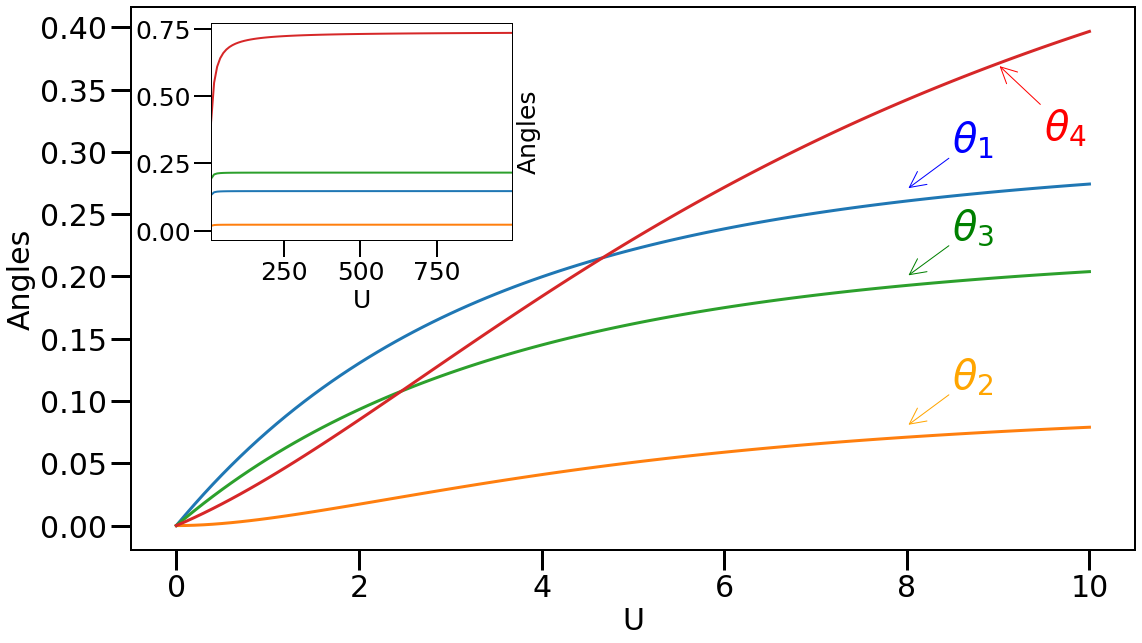

In [305]:
#jims_angles[0] = 0
jims_angles_transpose = jims_angles.transpose()
left, bottom, width, height = [0.08, 0.57, 0.3, 0.4]
fig, ax1 = plt.subplots(figsize=(18, 10))
axins = ax1.inset_axes([left,bottom,width,height])

ax1.set_ylabel('Angles', fontsize =30)
ax1.plot(u_list, abs(jims_angles_transpose[0]), linewidth = 3)
ax1.annotate(r'$\theta_4$', xy = (9,0.37), xytext = (9.5,0.31),
            arrowprops={'arrowstyle': '->', 'color':'red'}, size=40, color = 'red')

ax1.plot(u_list, abs(jims_angles_transpose[1]), linewidth = 3)
ax1.annotate(r'$\theta_1$', xy = (8,0.27), xytext = (8.5,0.30),
            arrowprops={'arrowstyle': '->', 'color':'blue'},size=40, color = 'blue')

ax1.plot(u_list, abs(jims_angles_transpose[2]), linewidth = 3)
ax1.annotate(r'$\theta_3$', xy = (8,0.20), xytext = (8.5,0.23),
            arrowprops={'arrowstyle': '->', 'color':'green'},size=40, color = 'green')

ax1.plot(u_list, abs(jims_angles_transpose[3]), linewidth = 3)
ax1.annotate(r'$\theta_2$', xy = (8,0.08), xytext = (8.5,0.11),
            arrowprops={'arrowstyle': '->', 'color' : 'orange'},size=40, color = 'orange')

axins.plot(u_list_1000, abs(jims_angles_1000_transpose[0]), linewidth = 2)
axins.plot(u_list_1000, abs(jims_angles_1000_transpose[1]), linewidth = 2)
axins.plot(u_list_1000, abs(jims_angles_1000_transpose[2]), linewidth = 2)
axins.plot(u_list_1000, abs(jims_angles_1000_transpose[3]), linewidth = 2)
#axins.annotate('Angle 4', xy = (600,0.70), xytext = (590,0.60),
            #arrowprops={'arrowstyle': '->'})
#axins.annotate('Angle 1', xy = (600,0.31), xytext = (590,0.45),
            #arrowprops={'arrowstyle': '->'})
#axins.annotate('Angle 3', xy = (600,0.20), xytext = (400,0.15),
            #arrowprops={'arrowstyle': '->'})
#axins.annotate('Angle 2', xy = (600,0.08), xytext = (700,0.01),
            #arrowprops={'arrowstyle': '->'})
    
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
    axins.spines[axis].set_linewidth(1)

ax1.xaxis.set_tick_params(width=3)
ax1.yaxis.set_tick_params(width=3)

axins.xaxis.set_tick_params(width=2)
axins.yaxis.set_tick_params(width=2)

axins.set_xlim(10,998)
ax1.set_xlabel('U', fontsize=30)
axins.set_xlabel('U', fontsize=25)
axins.set_ylabel('Angles', fontsize=25)
axins.yaxis.set_label_position("right")

ax1.tick_params(axis='both', labelsize=30, length=20)
axins.tick_params(axis='both', labelsize=25, length=17)
plt.show()

In [282]:
u_start = 0.0
u_end = 1000
nstep = 101
u_list_1000 = np.linspace(u_start, u_end, nstep)
gs_vector_1000 = []
for i in range(len(u_list_1000)):
    #print(u_list[i])
    gs_vector_1000.append(groundstate(u_list_1000[i]))
    
sol_1000 = []

for i in range(len(u_list_1000)):
    
    sol_1000.append(np.roots((1, -3*u_list_1000[i], 2*(u_list_1000[i] ** 2 - 8), 24*u_list_1000[i])))
    
ge_1000= []
for i in range(len(sol_1000)):
    
    ge_1000.append(np.min(sol_1000[i]))
    
for i in range(len(gs_vector_1000)):
    if gs_vector_1000[i][3] < 0:
        gs_vector_1000[i] *= -1
    #print(gs_vector[i])
    
jims_angles_1000 = np.zeros([len(u_list_1000), 4])
for i in range(len(u_list_1000)):
    jims_angles_1000[i][0] = 0.5*np.arcsin(2*gs_vector_1000[i][5])
    jims_angles_1000[i][1] = np.arctan((np.tan(jims_angles_1000[i][0]))**2)
    jims_angles_1000[i][2] = 0.5*np.arcsin(2*np.sqrt(2)*gs_vector_1000[i][5] / (np.cos(jims_angles_1000[i][0])**2 * np.cos(jims_angles_1000[i][1])+np.sin(jims_angles_1000[i][0])**2 * np.sin(jims_angles_1000[i][1])))
    jims_angles_1000[i][3] = np.arctan(gs_vector_1000[i][-1]/gs_vector_1000[i][0]) - np.arctan(np.tan(jims_angles_1000[i][2])**2)

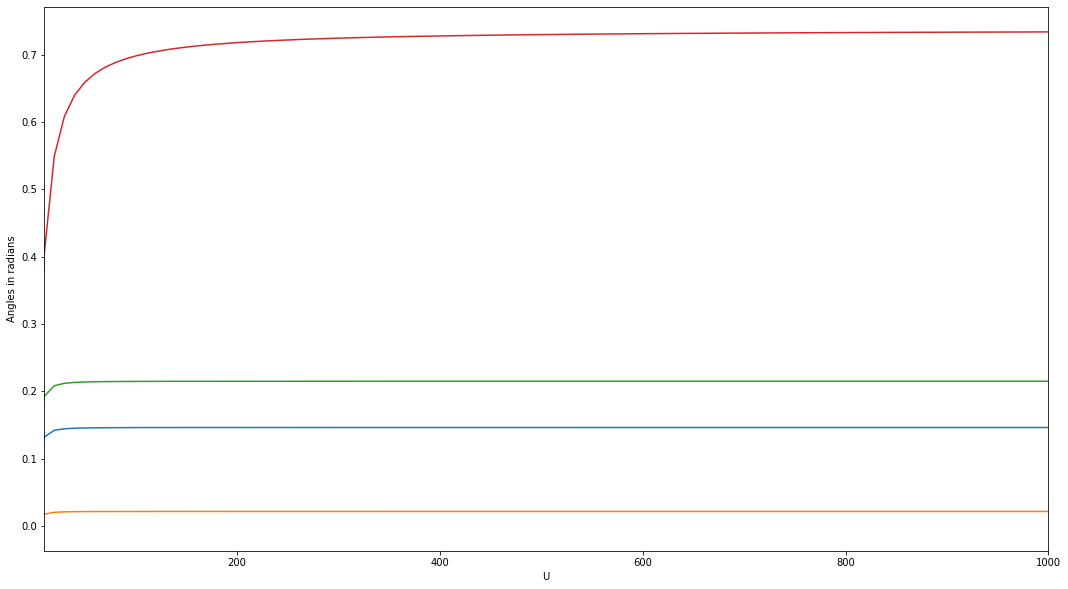

In [286]:
jims_angles_1000_transpose = jims_angles_1000.transpose()
fig, ax1 = plt.subplots(figsize=(18, 10))
ax1.set_ylabel('Angles in radians')
ax1.plot(u_list_1000, abs(jims_angles_1000_transpose[0]))
ax1.plot(u_list_1000, abs(jims_angles_1000_transpose[1]))
ax1.plot(u_list_1000, abs(jims_angles_1000_transpose[2]))
ax1.plot(u_list_1000, abs(jims_angles_1000_transpose[3]))
plt.xlim((10,1000))
ax1.set_xlabel('U')

plt.show()

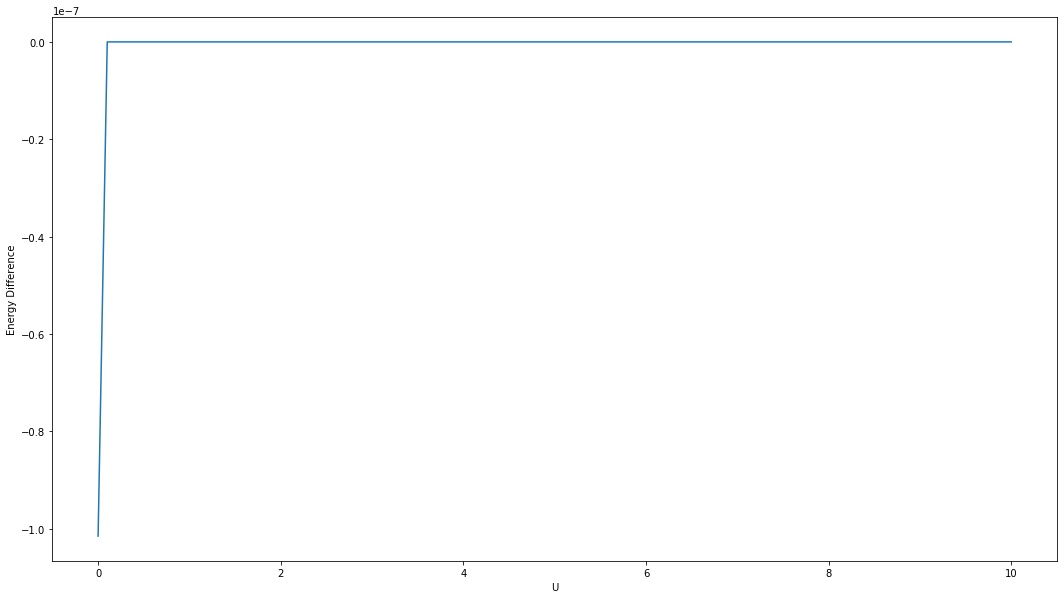

In [289]:
jims_variational_energy = []
for i in range((len(u_list))):
    jims_variational_energy.append(np.dot(jim_psi_doubles[i], np.dot(hamm(u_list[i]), jim_psi_doubles[i]))) #/ LA.norm(new_psi_doubles[i]))

jims_exact_difference = []
for i in range(len(ge)):
    jims_exact_difference.append(ge[i] - jims_variational_energy[i])
    
fig, ax1 = plt.subplots(figsize=(18, 10))
ax1.plot(u_list, jims_exact_difference)
ax1.set_ylabel('Energy Difference')
ax1.set_xlabel('U')
#plt.ylim((-0.00001, 0.0001))
#plt.legend()
plt.show()

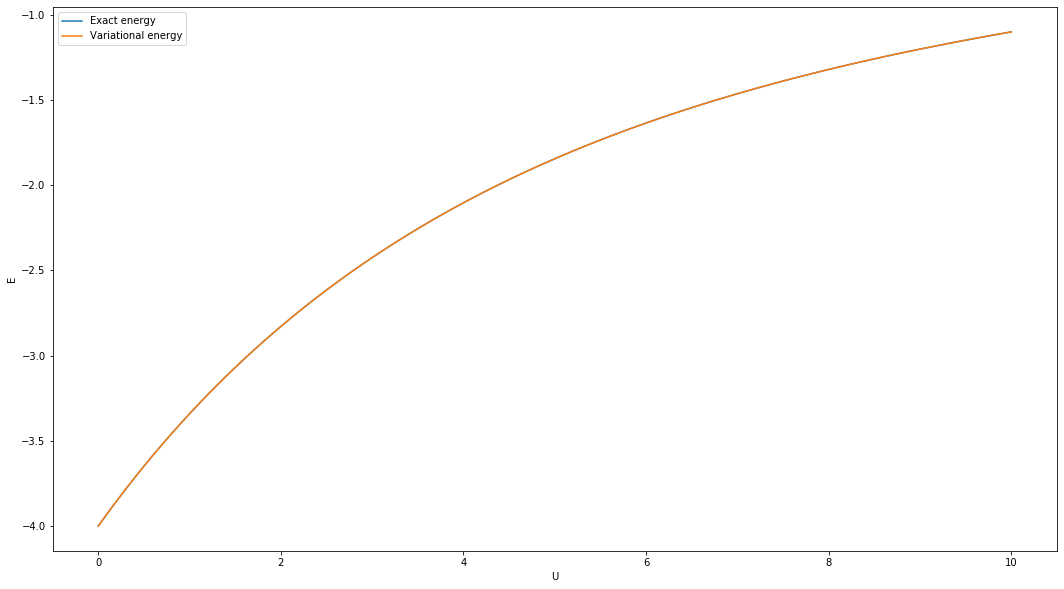

In [290]:
fig, ax1 = plt.subplots(figsize=(18, 10))
ax1.set_ylabel('E')
ax1.plot(u_list, ge, label = 'Exact energy')
ax1.plot(u_list, jims_variational_energy, label = 'Variational energy')
ax1.set_xlabel('U')
#ax1.sex_ylabel('E')
#plt.ylim((-0.00001, 0.0001))
plt.legend()
plt.show()

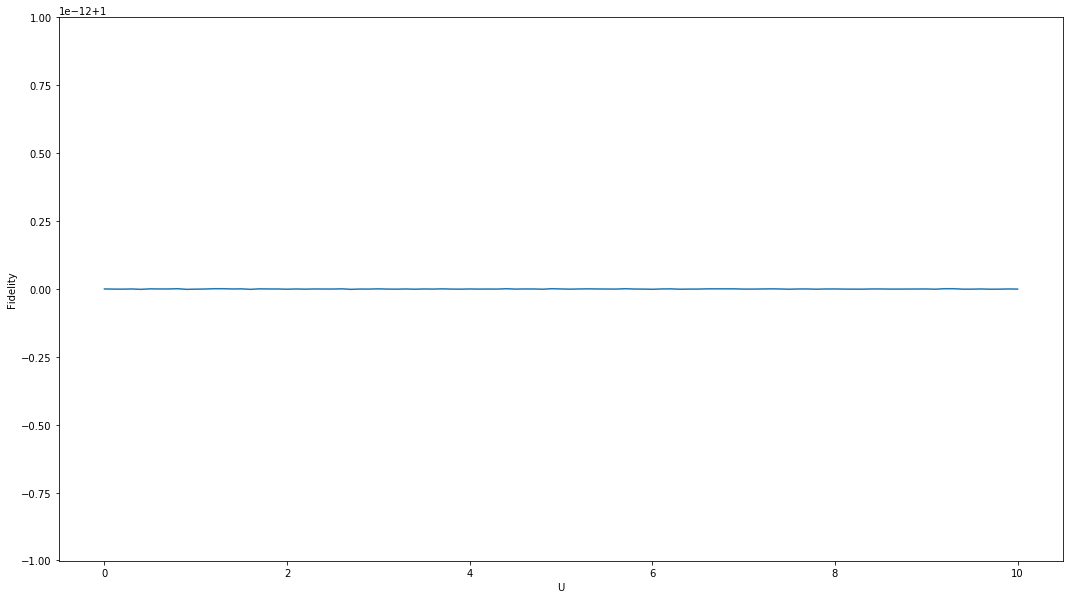

In [291]:
jims_fidelity = []
for i in range(len(ge)):
    jims_fidelity.append((np.dot(jim_psi_doubles[i], gs_vector[i])) ** 2)
    
fig, ax1 = plt.subplots(figsize=(18, 10))
ax1.plot(u_list, jims_fidelity)
ax1.set_ylabel('Fidelity')
ax1.set_xlabel('U')
#plt.ylim((-0.00001, 0.0001))
#plt.legend()
plt.show()

In [326]:
def newapp_1(vector):
    
    exponent = np.zeros([len(basis),len(basis)])
    theta = list(vector)
    temp1 = np.dot(LA.expm(theta[0] *-1* ucc_doubles[0]), initial)
    #print(temp1)
    temp2 = np.dot(LA.expm(theta[0] *-1* ucc_doubles[1]), temp1)
    #print(temp2)
    #temp3 = np.dot(LA.expm(theta[1] * ucc_quads[0]), temp2)
    #print(temp3)
    temp4 = np.dot(LA.expm(-np.pi/4 * ucc_doubles[2]), temp2)
    #print(temp4)
    temp5 = np.dot(LA.expm(theta[2] * ucc_doubles[3]), temp4)
    #print(temp5)
    temp6 = np.dot(LA.expm(theta[2] * ucc_doubles[4]), temp5)
    #print(temp6)
    temp7 = np.dot(LA.expm(theta[2] *-1* ucc_doubles[6]), temp6)
    #print(temp7)
    temp8 = np.dot(LA.expm(theta[2] *-1* ucc_doubles[7]), temp7)
    #print(temp8)
    temp9 = np.dot(LA.expm(theta[3] *-1* ucc_doubles[5]), temp8)
    #print(temp9)
    
    #exponent = theta[0] * ucc_doubles[0] + theta[0] * ucc_doubles[1] + theta[1] * ucc_quads[0] + (-1*np.pi/4 * ucc_doubles[2]) + theta[2] * ucc_doubles[3] + theta[2] * ucc_doubles[4] + theta[2] * ucc_doubles[6] + theta[2] * ucc_doubles[7] + theta[3] * ucc_doubles[5]
    #print(exp_total)
    return temp9 #LA.expm(exponent) 

In [327]:
jim1_psi_doubles = []
for i in range(len(u_list)):
    jim1_psi_doubles.append(newapp_1(jims1_angles[i]))
jim1_psi_doubles[10], gs_vector[10]

(array([ 0.70046955,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03765323,  0.        ,  0.        ,  0.        ,  0.        ,
         0.07530769,  0.        ,  0.        ,  0.        , -0.02862459,
         0.03765323,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03765323, -0.70025341,  0.        ,  0.        ,  0.        ,
         0.07530769,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03734732,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03431606]),
 array([ 0.70048107, -0.        , -0.        , -0.        , -0.        ,
         0.03765385, -0.        , -0.        , -0.        , -0.        ,
         0.07530769, -0.        , -0.        , -0.        , -0.02862506,
         0.03765385, -0.        , -0.        , -0.        , -0.        ,
         0.03765385, -0.70048107, -0.        , -0.        , -0.        ,
         0.07530769, -0.        , -0.        , -0.        , -0.        ,
         0.03765385, -0.    

In [329]:
jims1_angles = np.zeros([len(u_list), 4])
for i in range(len(u_list)):
    jims1_angles[i][0] = 0.5*np.arcsin(4*gs_vector[i][5])
    jims1_angles[i][1] = np.arctan((np.tan(jims1_angles[i][0]))**2)
    jims1_angles[i][2] = 0.5*np.arcsin(2*np.sqrt(2)*gs_vector[i][5] / (np.cos(jims1_angles[i][0])**2)) #* np.cos(jims1_angles[i][1])+np.sin(jims1_angles[i][0])**2 * np.sin(jims1_angles[i][1])))
    jims1_angles[i][3] = np.arctan(gs_vector[i][-1]/gs_vector[i][0]) - np.arctan(np.tan(jims1_angles[i][2])**2)

In [330]:
jim1_psi_doubles = []
for i in range(len(u_list)):
    jim1_psi_doubles.append(newapp_1(jims1_angles[i]))

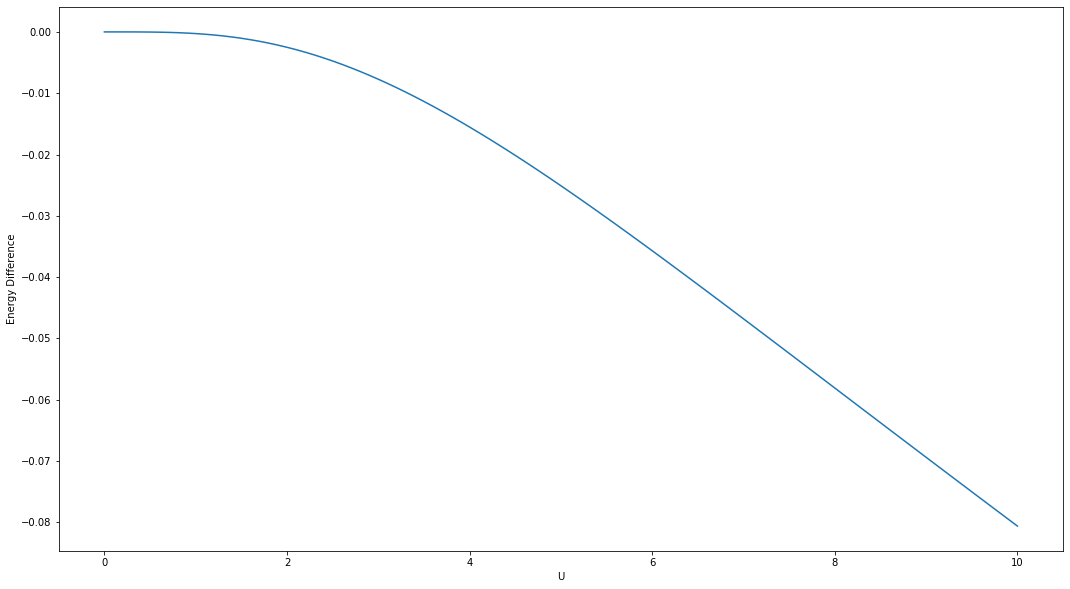

In [331]:
jims1_variational_energy = []
for i in range(len(u_list)):
    jims1_variational_energy.append(np.dot(jim1_psi_doubles[i], np.dot(hamm(u_list[i]), jim1_psi_doubles[i]))) #/ LA.norm(new_psi_doubles[i]))

jims1_exact_difference = []
for i in range(len(ge)):
    jims1_exact_difference.append(ge[i] - jims1_variational_energy[i])
    
fig, ax1 = plt.subplots(figsize=(18, 10))
ax1.plot(u_list, jims1_exact_difference)
ax1.set_ylabel('Energy Difference')
ax1.set_xlabel('U')
#plt.ylim((-0.00001, 0.0001))
#plt.legend()
plt.show()

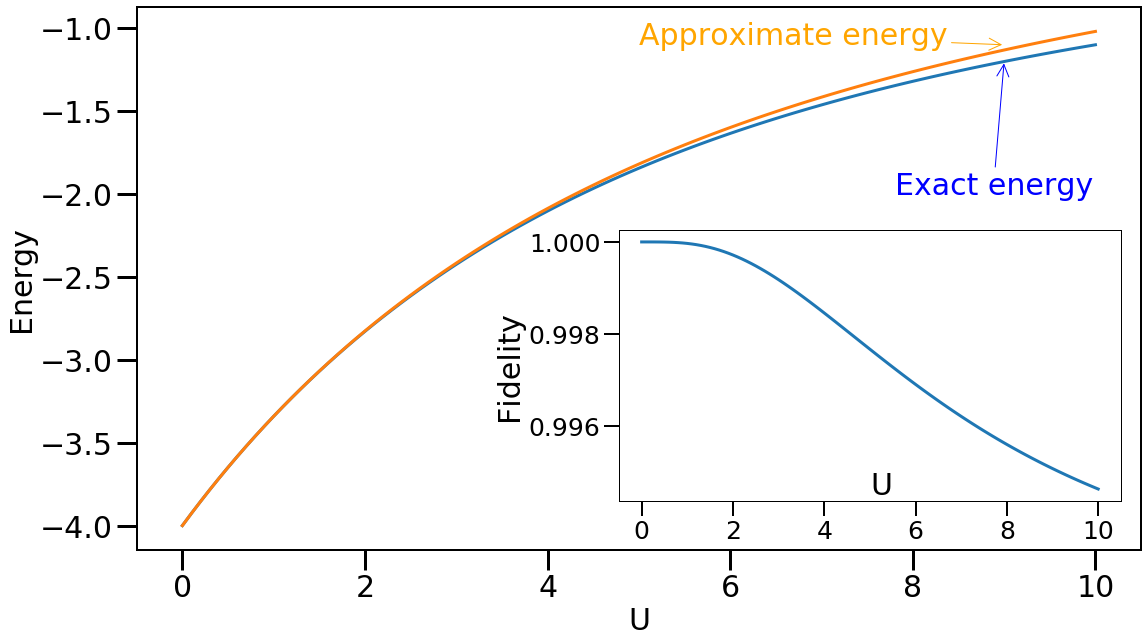

In [332]:
fig, ax1 = plt.subplots(figsize=(18, 10))
left, bottom, width, height = [0.48, 0.09, 0.5, 0.5]
axins = ax1.inset_axes([left,bottom,width,height])
ax1.set_ylabel('Energy', fontsize=30)
axins.set_ylabel('Fidelity', fontsize=30)
ax1.plot(u_list, ge, linewidth=3)
ax1.plot(u_list, jims1_variational_energy, linewidth=3)
ax1.annotate('Approximate energy', xy = (9,-1.1), xytext = (5.0,-1.1),
            arrowprops={'arrowstyle': '->', 'color':'orange'}, size=30, color = 'orange')


ax1.annotate('Exact energy', xy = (9,-1.2), xytext = (7.8,-2.0),
            arrowprops={'arrowstyle': '->', 'color':'blue'}, size=30, color = 'blue')


for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)
    axins.spines[axis].set_linewidth(1)

ax1.xaxis.set_tick_params(width=3)
ax1.yaxis.set_tick_params(width=3)

axins.xaxis.set_tick_params(width=2)
axins.yaxis.set_tick_params(width=2)

axins.plot(u_list, jims1_fidelity, linewidth=3)
ax1.set_xlabel('U', fontsize=30)

axins.text(5,0.9945,'U', fontsize=30)

ax1.tick_params(axis='both', labelsize=30, length=20)
axins.tick_params(axis='both', labelsize=25, length=15)
plt.show()

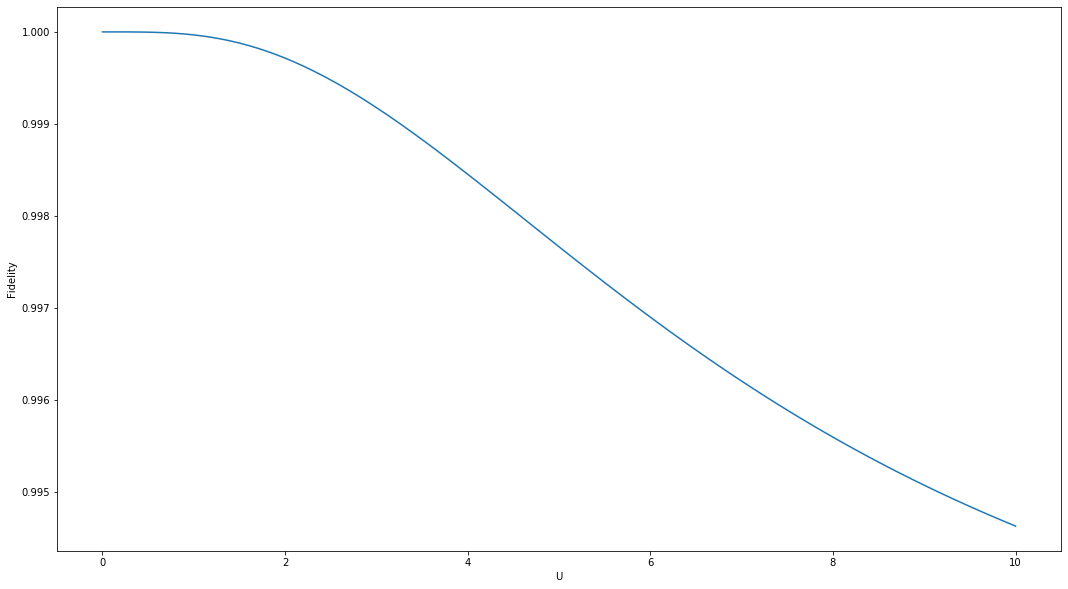

In [333]:
jims1_fidelity = []
for i in range(len(ge)):
    jims1_fidelity.append((np.dot(jim1_psi_doubles[i], gs_vector[i])) ** 2)
    
fig, ax1 = plt.subplots(figsize=(18, 10))
ax1.plot(u_list, jims1_fidelity)
ax1.set_ylabel('Fidelity')
ax1.set_xlabel('U')
#plt.ylim((-0.00001, 0.0001))
#plt.legend()
plt.show()

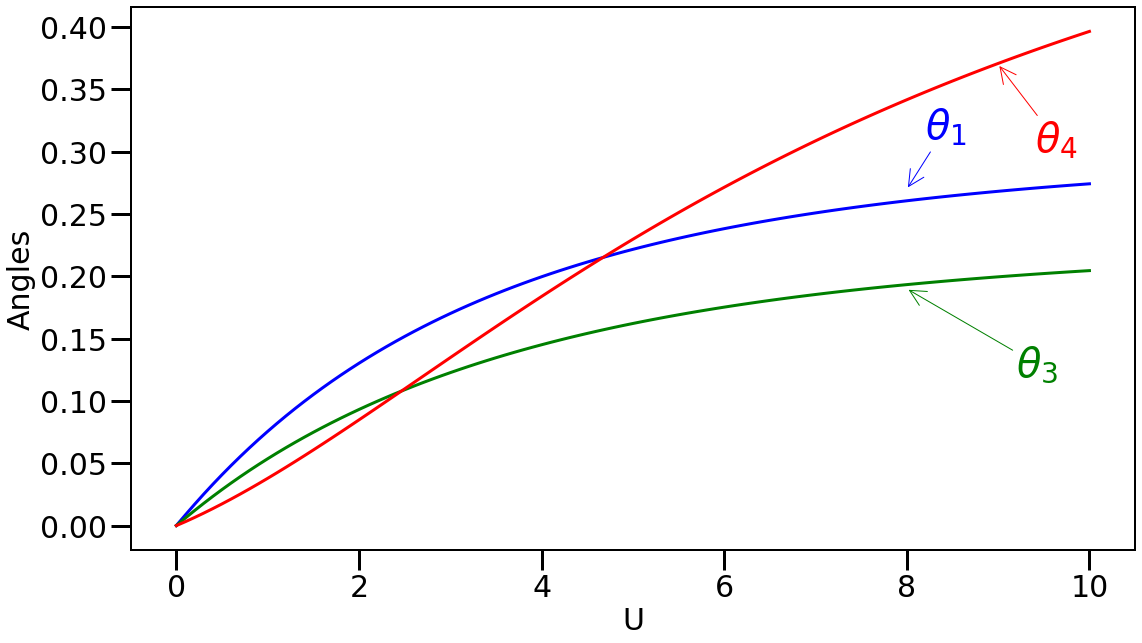

In [334]:
jims1_angles_transpose = jims1_angles.transpose()
left, bottom, width, height = [0.05, 0.50, 0.3, 0.5]
fig, ax1 = plt.subplots(figsize=(18, 10))

ax1.set_ylabel('Angles', fontsize =30)
ax1.plot(u_list, abs(jims1_angles_transpose[0]), linewidth = 3, color = 'blue')
ax1.annotate(r'$\theta_4$', xy = (9,0.37), xytext = (9.4,0.30),
            arrowprops={'arrowstyle': '->', 'color':'red'}, size=40, color = 'red')

ax1.annotate(r'$\theta_1$', xy = (8,0.27), xytext = (8.2,0.31),
            arrowprops={'arrowstyle': '->', 'color':'blue'},size=40, color = 'blue')

ax1.plot(u_list, abs(jims1_angles_transpose[2]), linewidth = 3, color = 'green')
ax1.annotate(r'$\theta_3$', xy = (8,0.19), xytext = (9.2,0.12),
            arrowprops={'arrowstyle': '->', 'color':'green'},size=40, color = 'green')

ax1.plot(u_list, abs(jims1_angles_transpose[3]), linewidth = 3, color = 'red')
    
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(2)

ax1.xaxis.set_tick_params(width=3)
ax1.yaxis.set_tick_params(width=3)


ax1.set_xlabel('U', fontsize=30)

ax1.tick_params(axis='both', labelsize=30, length=20)
axins.tick_params(axis='both', labelsize=20, length=10)
plt.show()